# Gradient Boosting Trees on the Taiwon Bankrupt data

We'll start this project the same way we've started the others: preparing the data and building our model, and this time with a new ensemble(bagging) model. Once it's working, we'll learn some new performance metrics to evaluate it.

**Importing Labraries**

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import pickle

from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix
)
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from ipywidgets import interact
from sklearn.pipeline import Pipeline, make_pipeline

**Creating a Wrangling Function**

In [4]:
def wrangle(file_path):
    df = pd.read_json(file_path)
    
    df ["bankrupt"] = df["Bankrupt?"]>0
    
    df.drop(columns=["Bankrupt?", "Total expense", "Total income", "Current Liabilities", "Inventory", "Working Capital", "Current Assets", "Quick Assets", "Cash",
                "Inventory and accounts receivable", "Net profit before tax", "Operating profit", "Contingent liabilities", "Net worth",
                 "Total debt", "Non-industry income and expenditure"], inplace=True)
    
    return df

In [3]:
df = wrangle("taiwon_bankruptcy_data.json")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 77 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   ROA(C) before interest and depreciation before interest  6819 non-null   float64
 1   ROA(A) before interest and % after tax                   6819 non-null   float64
 2   ROA(B) before interest and depreciation after tax        6819 non-null   float64
 3   Operating Gross Margin                                   6819 non-null   float64
 4   Realized Sales Gross Margin                              6819 non-null   float64
 5   Operating Profit Rate                                    6819 non-null   float64
 6   Pre-tax net Interest Rate                                6819 non-null   float64
 7   After-tax net Interest Rate                              6819 non-null   float64
 8   Continuous interest rate (af

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Continuous interest rate (after tax),Operating Expense Rate,...,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability,bankrupt
0,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.780985,1.256969e-04,...,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469,True
1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.781506,2.897851e-04,...,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794,True
2,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.780284,2.361297e-04,...,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474,True
3,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.781241,1.078888e-04,...,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982,True
4,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.781550,7.890000e+09,...,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490,True


### Split

Create your feature matrix X and target vector y. Your target is "bankrupt".

In [5]:
target = "bankrupt"

y = df[target]
X = df.drop(columns=[target])

Divide the data (X and y) into training and test sets using a randomized train-test split. test set should be 20% of your total data. And set a random_state for reproducibility

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=40
)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5455, 76)
(5455,)
(1364, 76)
(1364,)


### baseline

In [6]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("accuracy baseline:", acc_baseline)

accuracy baseline: 0.9686526122823098


### Resample

Create a new feature matrix X_train_over and target vector y_train_over by performing random over-sampling on the training data.

In [7]:
over_sampler = RandomOverSampler(random_state=40)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)

print(X_train_over.shape)
X_train_over.head()

(10568, 76)


,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Continuous interest rate (after tax),Operating Expense Rate,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,0.458685,0.454154,0.508432,0.576111,0.576111,0.998487,0.796446,0.808405,0.780658,2.015544e-04,...,0.744635,0.003754,0.623349,0.576107,0.835667,0.280350,0.026620,0.564182,1,0.027308
1,0.460830,0.511121,0.512875,0.613824,0.613846,0.999073,0.797296,0.809228,0.781469,2.204032e-04,...,0.779891,0.003578,0.623892,0.613825,0.838791,0.279278,0.026504,0.563281,1,0.031291
2,0.534052,0.582316,0.579046,0.604715,0.604715,0.999086,0.797629,0.809488,0.781761,6.060000e+09,...,0.824112,0.002887,0.622335,0.604710,0.842178,0.279005,0.026815,0.565268,1,0.032620
3,0.435187,0.503598,0.502543,0.614869,0.615150,0.998929,0.797187,0.809198,0.781445,3.859946e-04,...,0.778489,0.000431,0.623888,0.614866,0.838912,0.277383,0.026787,0.565138,1,0.046061
4,0.521279,0.611971,0.575245,0.661994,0.661994,0.999586,0.798297,0.810146,0.782231,4.800071e-04,...,0.830972,0.005061,0.625087,0.661992,0.843016,0.280308,0.026856,0.565449,1,0.027435


### Iterate

Creating a pipeline named clf (short for "classifier") that contains a SimpleImputer transformer and a GradientBoostingClassifier predictor.

In [8]:
clf = make_pipeline(
    SimpleImputer(),
    GradientBoostingClassifier()
)

Create a dictionary with the range of hyperparameters that we want to evaluate for our classifier.

>For the SimpleImputer, try both the "mean" and "median" strategies.

>For the GradientBoostingClassifier, try max_depth settings between 2 and 5.

>Also for the GradientBoostingClassifier, try n_estimators settings between 20 and 31, by steps of 5.

In [9]:
params = {
    "simpleimputer__strategy": ["mean", "median"],
    "gradientboostingclassifier__n_estimators": range(20, 31, 5),
    "gradientboostingclassifier__max_depth": range(2,5)
}
params

{'simpleimputer__strategy': ['mean', 'median'],
 'gradientboostingclassifier__n_estimators': range(20, 31, 5),
 'gradientboostingclassifier__max_depth': range(2, 5)}

 Creating a GridSearchCV named model that includes your classifier and hyperparameter grid. i will be using the same arguments for cv and n_jobs that you used above, and set verbose to 1.

In [10]:
model = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)

In [ ]:
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


Extract the cross-validation results from model and load them into a DataFrame named cv_results.

Get cross-validation results from a hyperparameter search in scikit-learn.

In [26]:
cv_result = pd.DataFrame(model.cv_results_)
cv_result.sort_values("rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gradientboostingclassifier__max_depth,param_gradientboostingclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
17,29.486747,2.516907,0.037580,0.019446,4,30,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.962630,0.962157,0.964995,0.964032,0.965452,0.963853,0.001286,1
16,31.972726,0.153772,0.047573,0.006913,4,30,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.962630,0.962157,0.964995,0.964032,0.963559,0.963475,0.001008,2
15,26.715132,0.521753,0.040776,0.001719,4,25,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.958846,0.956954,0.960738,0.961193,0.961666,0.959879,0.001748,3
14,26.007735,0.277671,0.041777,0.005703,4,25,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.958846,0.956954,0.960738,0.961193,0.961666,0.959879,0.001748,3
13,21.036776,0.245113,0.049772,0.014012,4,20,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.951277,0.954588,0.957427,0.956933,0.960246,0.956094,0.003006,5
12,20.561848,0.137250,0.043176,0.001938,4,20,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.951277,0.954588,0.957427,0.956933,0.958353,0.955716,0.002543,6
10,23.469985,0.318546,0.051172,0.010808,3,30,mean,"{'gradientboostingclassifier__max_depth': 3, '...",0.938978,0.937559,0.946074,0.936110,0.937056,0.939155,0.003581,7
11,23.825582,0.230357,0.040579,0.002058,3,30,median,"{'gradientboostingclassifier__max_depth': 3, '...",0.938978,0.937559,0.946074,0.936110,0.936583,0.939061,0.003641,8
8,19.436691,0.423665,0.046574,0.008727,3,25,mean,"{'gradientboostingclassifier__max_depth': 3, '...",0.927625,0.914853,0.928571,0.930431,0.926171,0.925530,0.005515,9
9,19.771699,0.115146,0.045574,0.010512,3,25,median,"{'gradientboostingclassifier__max_depth': 3, '...",0.927152,0.914853,0.928571,0.930431,0.926171,0.925436,0.005482,10


In [28]:
model.best_params_

{'gradientboostingclassifier__max_depth': 4,
 'gradientboostingclassifier__n_estimators': 30,
 'simpleimputer__strategy': 'median'}

### Evaluate

Now that i have a working model that's actually giving us something useful, let's see how good it really is.

Calculate the training and test accuracy scores for model.

In [31]:
acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)
print("training accuracy:", acc_train.round())
print("test accuracy:", acc_test.round(2))

training accuracy: 1.0
test accuracy: 0.92


Just like before, let's make a confusion matrix to see how our model is making its correct and incorrect predictions.

Plot a confusion matrix that shows how your best model performs on your test set.

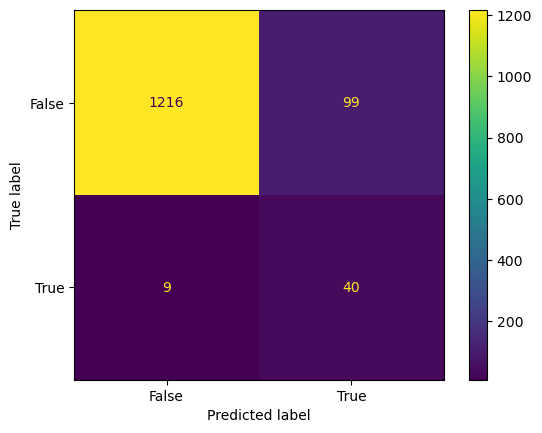

In [38]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

Print the classification report for your model, using the test set.

In [40]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

       False       0.99      0.92      0.96      1315
        True       0.29      0.82      0.43        49

    accuracy                           0.92      1364
   macro avg       0.64      0.87      0.69      1364
weighted avg       0.97      0.92      0.94      1364

